# Lab 1: Data exploration

In HW1, we did some basic data exploration and visualization. In this lab, we will continue digging through the data sets on the open data portal for more data wrangling and exploration practice. 


In addition to general data exploration, we also focus on geographical visualizations.

To start we'll need to install the following python libraries:
- geopandas
- folium

Install them with pip/conda:

<code>pip install geopandas
pip install folium
</code>

## Import libraries

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [25]:
from platform import python_version
print(python_version())

3.5.2


As you've probably noticed while doing your homework, different neighborhoods/zipcodes have different distributions of 311 requests. We will attempt to visualize these differences.

Before we start, we'll need an the boundaries of the Chicago zipcodes, which we can get from: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-ZIP-Codes/gdcf-axmw

First let's load our datasets and the zipcode geojson.

In [68]:
size = 20000
# Change these filepaths

df = pd.read_csv('../data/311_Service_Requests_Graffiti_2019.csv',nrows=size)
geo_df = gpd.read_file('../data/chi_boundaries.geojson')

In [69]:
geo_df.dropna(inplace=True)
df.drop(['STATE', 'CITY', 'LEGACY_SR_NUMBER', 'PARENT_SR_NUMBER'], axis=1, inplace=True)
df.dropna(inplace=True)
df['zip'] = df['ZIP_CODE'].astype(int)
geo_df['zip'] = geo_df['zip'].astype(int)

## Choropleth Maps with geopandas
geopandas.read_file takes in a geojson file and creates a GeoDataFrame. You can read more about it from the [geopandas api](http://geopandas.org/data_structures.html). The GeoDataFrame can then be plotted right off the bat:

In [28]:
geo_df.head()

,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,(POLYGON ((-87.67762151065281 41.9177578010629...
1,34,127476050.762,48103.7827213,60639,(POLYGON ((-87.72683253163021 41.9226462671259...
2,35,45069038.4783,27288.6096123,60707,(POLYGON ((-87.78500237831095 41.9091478547167...
3,36,70853834.3797,42527.9896789,60622,(POLYGON ((-87.6670686895295 41.88885188496992...
4,37,99039621.2518,47970.1401531,60651,(POLYGON ((-87.70655631674127 41.8955534069940...


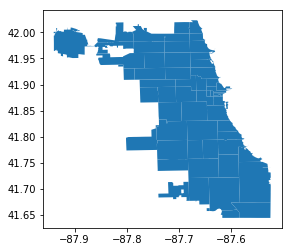

In [29]:
geo_df.plot()

This is not too interesting so let's try to make the plot tell us something about each of the zipcodes. We can do this by setting the column parameter which will then shade the zipcode block according to that column. You can supply a [matplotlib colormap](https://matplotlib.org/examples/color/colormaps_reference.html) string for the cmap parameter for different types of color gradients.

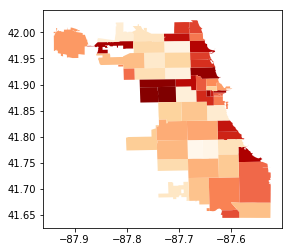

In [30]:
geo_df.plot(column='shape_area', cmap='OrRd')

Now, let's augment this geoDataFrame with a new column for the number of 311 requests of graffiti complaints to see something a bit more interesting. To do this we'll create a dataframe for the number of 311 requests that each zipcode received in aggregate, and merge this to geo_df

In [31]:
# Get the counts
zip_counts = df.groupby('zip').count()
# Make a smaller dataframe with two columns: "zip" and "count"
zipcounts = pd.DataFrame({'zip': zip_counts.index, 'count': zip_counts['STATUS']})
print(zipcounts.head())

       count    zip
zip                
60601     78  60601
60602     20  60602
60603     19  60603
60604      9  60604
60605     66  60605


In [32]:
# Join them onto geo_df
joined = geo_df.join(zipcounts, on='zip', how='left', lsuffix='l', rsuffix='r').dropna()    

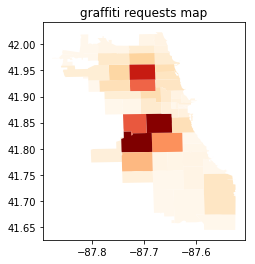

In [33]:
# Plot the map color coded by number of graffiti 311 requests
joined.plot(column='count', cmap='OrRd')
plt.title('graffiti requests map')
plt.show()

## Heatmaps with folium

While these visualizations are useful in summarizing where we might expect more graffiti requests to come from, they're a bit coarse because zipcode blocks can be pretty big. To get a finer grained view of where these requests happen, we'll learn how to plot a heatmap of these 311 requests using folium.

Recall that our 311 data contains the latitude and longitude of these values.

In [34]:
xy = df[['LATITUDE', 'LONGITUDE']]

In [35]:
import folium
from folium.plugins import HeatMap

In [36]:
print(xy.mean())

LATITUDE     41.874676
LONGITUDE   -87.689482
dtype: float64


In [40]:
hmap = folium.Map(location=[41.87, -87.69], zoom_start=10)
hm_rod = HeatMap(list(zip(xy['LATITUDE'].values, xy['LONGITUDE'].values)), radius=15, blur=20)
hmap.add_child(hm_rod)

Play around with the zoom_start, radius and blur parameters to get a better sense of how they affect the resulting visualizations.

## Data Exploration Tips

Here are some things you want to do during data exploration:

1. Distributions of different variables
2. Correlations between variables - you can do a correlation matrix and turn it into a heatmap
3. Changes and trends over time - how does the data and the entities in the data change over time
4. Missing values - are there lots of missing values? is there any pattern there?
5. looking at outliers - this can be done using clustering (that we will cover later) but also using other methods by plotting distributions.
6. cross-tabs, describing how the different types of entities are different.

It's good to have code that does each of the things above. The exercises below are a start in helping you create that for yourself.


## Exercises:
Now that we've seen how to create some simple geographical visualizations you should aggregate the 311 requests by zipcode and visualize request frequency, average request completion time by location, and any other things you find interesting. Some specific questions that might be good to explore:


### Do certain neighborhoods get certain graffiti requests completed faster than others?




In [120]:
df['time_to_close'] = pd.to_datetime(df['CLOSED_DATE']) - pd.to_datetime(df['CREATED_DATE'])
df['time_to_close'].describe()

count                      9605
mean     1 days 08:41:03.797293
std      1 days 22:35:07.075863
min             0 days 00:00:27
25%             0 days 00:48:40
50%             1 days 02:04:11
75%             1 days 23:38:56
max            88 days 14:50:37
Name: time_to_close, dtype: object

In [121]:
zip_group = df.groupby('zip')
lst = []
for zip_code, zip_df in zip_group:
    lst.append({'zip':zip_code, 'avg_time_to_close':zip_df['time_to_close'].mean()})
zip_time = pd.DataFrame(lst)
zip_time = zip_time.set_index('zip')
zip_time['normalized_dt'] = zip_time['avg_time_to_close'] / zip_time['avg_time_to_close'].max()


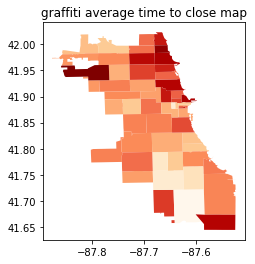

In [124]:
joined2 = geo_df.join(zip_time, on='zip', how='left', lsuffix='l', rsuffix='r').dropna()
joined2.plot(column='normalized_dt', cmap='OrRd')
plt.title('graffiti average time to close map')
plt.show()

### Is there any seasonality to the requests? what about seasonal variations in completion times?

In [ ]:
#code

### Are there any outliers in terms of time periods or neighborhoods?

In [ ]:
# code

### Which neighborhoods are the most similar in terms of graffiti service requests being reported?

In [ ]:
# code

### References
http://pandas.pydata.org/pandas-docs/stable/timeseries.html

http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html

http://geopandas.org/mapping.html

http://geopandas.org/mergingdata.html

http://python-visualization.github.io/folium/docs-v0.5.0/index.html

### Examples
http://blog.yhat.com/posts/interactive-geospatial-analysis.html

https://alcidanalytics.com/p/geographic-heatmap-in-python